In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import**

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import os
from PIL import Image, ImageDraw
from matplotlib.path import Path
import pylab as plt
import math
import argparse
import glob
from math import sqrt, atan2, pi
from PIL import Image, ImageDraw
from math import sqrt, pi, cos, sin
from collections import defaultdict
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from itertools import combinations
from PIL import Image
from itertools import combinations, permutations
from google.colab.patches import cv2_imshow
import pickle

# **Corner Segmentation Function**

In [3]:
def get_convex_hull(img):
    img = img.copy()

    n, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    if n == 1:
        img[...] = 0
        pixels = np.array([[0,0]])
        area = 1
    else:
        max_index = stats[1:, cv2.CC_STAT_AREA].argmax() + 1
        img[labels != max_index] = 0
        img[labels == max_index] = 255
        pixels = np.transpose(np.where(labels == max_index))
        area = stats[max_index, cv2.CC_STAT_AREA]

    hull = cv2.convexHull(pixels).reshape(-1, 2)
    hull[:, [0, 1]]= hull[:, [1, 0]]

    return hull, area

def group_hull_vertex(hull, distance_threshold=0):
    '''
    Merge points in hull that are close to each other.
    '''
    vertex = list(hull)
    for i, u in enumerate(vertex):
        for j, v in enumerate(vertex):
            if i == j or u is None or v is None: continue
            if np.linalg.norm(u-v) < distance_threshold:
                vertex[i] = np.maximum(u, v)
                # vertex[i] = (u+v)//2
                vertex[j] = None
    hull = np.array([x for x in vertex if x is not None])

    return hull

def group_hull_edge(hull, angle_threshold=0.75):
    vertex = [hull[0], hull[1]]

    for i, u in enumerate(hull[2:]):
        # cross = np.cross(u-v, v-w) / np.linalg.norm(u-v) / np.linalg.norm(v-w)
        v, w = vertex[-1] - vertex[-2], u - vertex[-1]
        cos = np.dot(v, w) / np.linalg.norm(v) / np.linalg.norm(w)
        if cos > angle_threshold:
            vertex[-1] = u
        else:
            vertex.append(u)

    return np.array(vertex)

def get_candidate_edges(hull, width, height, EDGE_PROXIMITY=10):
    edges = []
    for i, (u, v) in enumerate(zip(hull, np.vstack((hull[1:], hull[:1])))):
            # Ignore hull edges that are near image edges
            if u[0] < EDGE_PROXIMITY and v[0] < EDGE_PROXIMITY: continue
            if u[1] < EDGE_PROXIMITY and v[1] < EDGE_PROXIMITY: continue
            if u[0] > width - EDGE_PROXIMITY and v[0] > width - EDGE_PROXIMITY: continue
            if u[1] > height - EDGE_PROXIMITY and v[1] > height - EDGE_PROXIMITY: continue
            edges.append((u, v))

    return np.array(edges)

def line_intersection(A, B):

    det = (A[1][0] - A[0][0]) * (B[0][1] - B[1][1]) - (A[1][1] - A[0][1]) * (B[0][0] - B[1][0])
    if det == 0: return [-1, -1]

    s = ((A[1][0] - A[0][0]) * (B[0][1] - A[0][1]) - (A[1][1] - A[0][1]) * (B[0][0] - A[0][0])) / det

    return (1-s)*B[0] + s*B[1]

def line_segment_intersection(P, v, A, B):
    '''
    Check whether a straight line intersects with a line segment.
    Parameters:
        - P: A point that lies on the straight line.
        - v: The directional vector of the straight line.
        - A, B: Two endpoints of the line segment. Represented by two 2D tuples.
    Returns: True or False, whether intersects or not.
    '''
    # P[0] + v[0]*t = (1-s) * A[0] + s * B[0]
    # P[1] + v[1]*t = (1-s) * A[1] + s * B[1]
    # <=>
    # v[0] * t + (A[0] - B[0]) * s = A[0] - P[0]
    # v[1] * t + (A[1] - B[1]) * s = A[1] - P[1]
 
    det = v[0] * (A[1] - B[1]) - v[1] * (A[0] - B[0])
    if det == 0: return False
 
    s = (v[0] * (A[1] - P[1]) - v[1] * (A[0] - P[0])) / det
    return (0 <= s <= 1)

def find_corners(edges, width, height, angle_threshold_parallel=0.9, angle_threshold_perpendicular=0.95):
    # Find longest edge
    max_edge = -1
    max_dist = 0
    for i, edge in enumerate(edges):
        dist = np.linalg.norm(edge[1] - edge[0])
        if dist > max_dist:
            max_dist = dist
            max_edge = i
    
    if max_edge == -1:
        return np.array([[0, 0], [width, 0], [width, height], [0, height]]), \
                -1,-1,-1,-1
    _max_edge = edges[max_edge][1] - edges[max_edge][0]
 
    # Find longest edge's parallel
    max_edge_parallel = -1
    max_dist_parallel = 0
    for i, edge in enumerate(edges):
        if i == max_edge: continue
        dist = np.linalg.norm(edge[1] - edge[0])
        # Check if parallel
        cos = np.dot(_max_edge, edge[1] - edge[0]) / dist / max_dist
        if abs(cos) < angle_threshold_parallel: continue
 
        if dist > max_dist_parallel:
            max_dist_parallel = dist
            max_edge_parallel = i
 
    # Find longest edge's perpendicular1
    max_edge_p1 = -1
    max_dist_p1 = 0
    for i, edge in enumerate(edges):
        if i == max_edge: continue
        if i == max_edge_parallel: continue
        dist = np.linalg.norm(edge[1] - edge[0])
        # Check if not parallel
        cos = np.dot(_max_edge, edge[1] - edge[0]) / dist / max_dist
        if abs(cos) > angle_threshold_perpendicular: continue
 
        if dist > max_dist_p1:
            max_dist_p1 = dist
            max_edge_p1 = i
 
    # Find longest edge's perpendicular2
    max_edge_p2 = -1
    max_dist_p2 = 0
    for i, edge in enumerate(edges):
        if i == max_edge: continue
        if i == max_edge_parallel: continue
        if i == max_edge_p1: continue
        dist = np.linalg.norm(edge[1] - edge[0])
        # Check if not parallel
        cos = np.dot(_max_edge, edge[1] - edge[0]) / dist / max_dist
        if abs(cos) > angle_threshold_perpendicular: continue
 
        if dist > max_dist_p2:
            max_dist_p2 = dist
            max_edge_p2 = i
 
    if max_edge == -1 or max_edge_parallel == -1 or max_edge_p1 == -1 or max_edge_p2 == -1:
        return np.array([[0, 0], [width, 0], [width, height], [0, height]]), \
                max_edge, max_edge_parallel, max_edge_p1, max_edge_p2
 
    return np.array([line_intersection(edges[max_edge], edges[max_edge_p1]),
                     line_intersection(edges[max_edge_p1], edges[max_edge_parallel]),
                     line_intersection(edges[max_edge_parallel], edges[max_edge_p2]),
                     line_intersection(edges[max_edge_p2], edges[max_edge]),], dtype=np.int32), \
            max_edge, max_edge_parallel, max_edge_p1, max_edge_p2

def order_points(pts):
    def centeroidpython(data):
        x, y = zip(*data)
        l = len(x)
        return sum(x) / l, sum(y) / l
 
    centroid_x, centroid_y = centeroidpython(pts)
    xy_sorted = sorted(pts, key = lambda x: np.arctan2((x[1]-centroid_y),(x[0]-centroid_x)))
    return np.array(xy_sorted)

def get_color_mask(img_hsv, lower_bound, upper_bound):
    hist = img_hsv[np.where(cv2.inRange(img_hsv[..., 0], lower_bound, upper_bound))]
    X = np.random.choice(hist[..., 1], 1000)

    # Calculate Gaussian Mixture Model
    gm = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42).fit(X.reshape(-1, 1))

    # # Plot the PDF.
    # plt.hist(X, bins=50)
    # xmin, xmax = plt.xlim()
    # ymin, ymax = plt.ylim()
    # x = np.linspace(xmin, xmax, 100)

    # p = norm.pdf(x, gm.means_[0, 0], np.sqrt(gm.covariances_[0])) * ymax
    # plt.plot(x, p, 'k', linewidth=2)
    # p = norm.pdf(x, gm.means_[1, 0], np.sqrt(gm.covariances_[1])) * ymax
    # plt.plot(x, p, 'k', linewidth=2)

    # plt.show()

    max_index = gm.means_.reshape(-1).argmax()
    gm_lower = gm.means_[max_index, 0] - 3*np.sqrt(gm.covariances_[max_index])
    gm_upper = gm.means_[max_index, 0] + 3*np.sqrt(gm.covariances_[max_index])

    ## GET COLOR MASK

    # Create color segmentation mask
    lower = (lower_bound, gm_lower, 60)
    upper = (upper_bound, gm_upper, 255)
    img_masked = cv2.inRange(img_hsv, lower, upper)

    hull, area = get_convex_hull(img_masked)

    return hull, area, img_masked


def detect_billiards_table(img):
    height, width = img.shape[:2]
    t = time()
 
    # Blur image
    img_blur = cv2.GaussianBlur(img, (11, 11), 0)
 
 
    # Convert to HSV color space and equalize histogram
    img_hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
    # img_hsv[1] = cv2.equalizeHist(img_hsv[1])
    # img_hsv[2] = cv2.equalizeHist(img_hsv[2])
 
    hull_blue, area_blue, img_masked = get_color_mask(img_hsv, 80, 130)
    hull_green, area_green, img_masked = get_color_mask(img_hsv, 40, 70)
 
    # Determine larger hull
    if area_blue > area_green:
        hull = hull_blue
        area = area_blue
    else:
        hull = hull_green
        area = area_green
 
    distance_threshold = np.sqrt(area) * 0.02
    hull = group_hull_vertex(hull, distance_threshold)
 
    angle_threshold=0.99
    hull = group_hull_edge(hull, angle_threshold)
 
    # # Show convex hull
    # img_hull = np.zeros_like(img)
    # img_hull = cv2.fillPoly(img_hull, [hull], color=(255, 255, 255))
    # for pts in hull:
    #     img_hull = cv2.circle(img_hull, tuple(pts), 3, color=(0,0,255), thickness=-1)
    # cv2_imshow(img_hull)
 
    EDGE_PROXIMITY = width * 0.02
 
    edges = get_candidate_edges(hull, width, height, EDGE_PROXIMITY)
 
    # img_hull = cv2.polylines(img.copy(), edges, isClosed=False, color=(0,0,255), thickness=2)
    # cv2_imshow(img_hull)
 
    angle_threshold_parallel = 0.85
    angle_threshold_perpendicular = 0.95
 
    pts, max_edge, max_edge_parallel, max_edge_p1, max_edge_p2 = find_corners(
        edges, width, height, angle_threshold_parallel, angle_threshold_perpendicular)
 
    img_hull = img.copy()
    img_hull = cv2.polylines(img_hull, [edges[max_edge]], isClosed=False, color=(0,0,255), thickness=3)
    img_hull = cv2.polylines(img_hull, [edges[max_edge_parallel]], isClosed=False, color=(0,255,0), thickness=3)
    img_hull = cv2.polylines(img_hull, [edges[max_edge_p1]], isClosed=False, color=(0,255,255), thickness=3)
    img_hull = cv2.polylines(img_hull, [edges[max_edge_p2]], isClosed=False, color=(255,0,255), thickness=3)
    # cv2_imshow(img_hull)
 
    # print(time() - t)
 
    BORDER_WIDTH = 100
    border_pts = pts + [BORDER_WIDTH, BORDER_WIDTH]
    img = cv2.copyMakeBorder(img, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, BORDER_WIDTH, cv2.BORDER_CONSTANT)
    img = cv2.polylines(img, [border_pts], isClosed=True, color=(0,0,255), thickness=2)
 
    return img, img_hull, order_points(pts) / [width, height]


def line_intersection(A, B):

    det = (A[1][0] - A[0][0]) * (B[0][1] - B[1][1]) - (A[1][1] - A[0][1]) * (B[0][0] - B[1][0])
    if det == 0: return None

    s = ((A[1][0] - A[0][0]) * (B[0][1] - A[0][1]) - (A[1][1] - A[0][1]) * (B[0][0] - A[0][0])) / det

    return (1-s)*B[0] + s*B[1]


def order_points(pts):
    def centeroidpython(data):
        x, y = zip(*data)
        l = len(x)
        return sum(x) / l, sum(y) / l
 
    centroid_x, centroid_y = centeroidpython(pts)
    xy_sorted = sorted(pts, key = lambda x: np.arctan2((x[1]-centroid_y),(x[0]-centroid_x)))
    return np.array(xy_sorted)

# **Ball Detection Function**

In [4]:
# Load image and resize 1000xX
def load_image(path): 

    img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w = img.shape[:2]
    if h > 1000:
        img = cv2.resize(img, (1000*w//h, 1000))

    return img

# Use polygon mask to remove background around the table
def remove_bg(img, pts):

    h, w = img.shape[:2]

    # 4 corners's coord
    top_left = pts[0]
    top_right = pts[1]
    bot_right = pts[2]
    bot_left = pts[3]

    # Create polygon mask
    polygon = [(bot_left[0]*w, bot_left[1]*h), (top_left[0]*w, top_left[1]*h), (top_right[0]*w, top_right[1]*h), (bot_right[0]*w, bot_right[1]*h)]
    img2 = Image.new('L', (w, h), 0)
    ImageDraw.Draw(img2).polygon(polygon, outline=1, fill=255)
    mask = np.array(img2)

    # Remove background
    masked = cv2.bitwise_and(img, img, mask=mask)

    return masked


# Hough circle: Detect ball
def hough_circle(img, img_draw):

    # Apply hough transform on the image
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=200, param2=13, minRadius=5, maxRadius=20)
  
    # Draw detected circles
    img_draw = img_draw.copy()
    if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                    # Draw outer circle
                    cv2.circle(img_draw, (i[0], i[1]), i[2], (0, 0, 255), 3)
                    
    else:
        print('No circle')

    return img_draw, circles

# Perspective transform image: from real angle to top-down angle

def perspective_trans(img, pts, new_w = 1000, new_h = 500):
    
    h, w = img.shape[:2]

    # 4 corners's coord
    top_left = pts[0]
    top_right = pts[1]
    bot_right = pts[2]
    bot_left = pts[3]

    # pts1: list of 4 corners's location in order: top_left, top_right, bot_left, bot_right
    # pts2: list of 4 coordinates in the result image
    pts1 = np.float32([[top_left[0]*w, top_left[1]*h], [top_right[0]*w, top_right[1]*h], [bot_left[0]*w, bot_left[1]*h], [bot_right[0]*w, bot_right[1]*h]])
    pts2 = np.float32([[0, 0], [new_w, 0], [0, new_h], [new_w, new_h]])

    # Implement transform
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    rst = cv2.warpPerspective(img, matrix, (new_w, new_h), cv2.INTER_LINEAR, borderValue=(255, 255, 255))

    return rst, matrix


# Identify which is the long edge
# return 0: top_left-top_right
# return 1: top_left-bot_left

def identify_edge(img, pts):

    h, w = img.shape[:2]

    # Perspective transform to 500x500
    img_trans, matrix = perspective_trans(img, pts, 500, 500)

    # Convert to GRAY, equalize histogram and blur image
    img_id = img_trans.copy()
    img_id = cv2.cvtColor(img_id, cv2.COLOR_BGR2GRAY)
    img_id = cv2.equalizeHist(img_id)
    blurred = cv2.GaussianBlur(img_id, (5, 5), 0)

    # Use threshold to focus on the holes
    (T, thresh) = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)

    # Create a mask having 4 white squares in the center of left, right, top, bottom
    mask = np.zeros(img_id.shape[:2], dtype = 'uint8') # mask: grayscale
    mask[225:275, :50] = 255 #left
    mask[0:50, 225:275] = 255 #top
    mask[225:275, 450:500] = 255 #right
    mask[450:500, 225:275] = 255 #bot

    # Apply mask with threshold image
    masked = cv2.bitwise_and(thresh, thresh, mask=mask)

    # Conditions:

    # T1, T2: 1 trong các ô (left, right)/(top/bot) hoàn toàn trắng
    T1 = ((masked[225:275, :50].astype(int).sum() == 637500) | (masked[225:275, 450:500].astype(int).sum() == 637500))
    T2 = ((masked[0:50, 225:275].astype(int).sum() == 637500) | (masked[450:500, 225:275].astype(int).sum() == 637500))

    # T3: left+right có nhiều màu đen hơn top+bot
    T3 = masked[225:275, :50].astype(int).sum() + masked[225:275, 450:500].astype(int).sum() < masked[0:50, 225:275].astype(int).sum() + masked[450:500, 225:275].astype(int).sum()

    # T4: (ô left/right có ít màu đen hơn) có nhiều màu đen hơn (ô top/bot có nhiều màu đen hơn)
    T4 = (max(masked[225:275, :50].astype(int).sum(), masked[225:275, 450:500].astype(int).sum()) < min(masked[0:50, 225:275].astype(int).sum(), masked[450:500, 225:275].astype(int).sum()))
    
    # T5: (ô left/right có nhiều màu đen hơn) có ít màu đen hơn (ô top/bot có ít màu đen hơn)
    T5 = (min(masked[225:275, :50].astype(int).sum(), masked[225:275, 450:500].astype(int).sum()) > max(masked[0:50, 225:275].astype(int).sum(), masked[450:500, 225:275].astype(int).sum()))
    
    # T6: top có nhiều màu đen hơn left, right
    T6 = masked[0:50, 225:275].astype(int).sum() < min(masked[225:275, :50].astype(int).sum(), masked[225:275, 450:500].astype(int).sum())

    # T7, T8: left, right có màu đen nhiều hơn một ngưỡng
    T7 = masked[225:275, :50].astype(int).sum() < 580000
    T8 = masked[225:275, 450:500].astype(int).sum() < 580000

    # T9: bot có ít màu đen hơn một ngưỡng 
    T9 = masked[450:500, 225:275].astype(int).sum() > 600000


    if(T1 & T2):
        if(T3):
            cv2.circle(img_trans, (10, 255), 15, (0, 255, 255), 3)
            cv2.circle(img_trans, (490, 255), 15, (0, 255, 255), 3)
            return img_trans, masked, 1

        else:
            cv2.circle(img_trans, (255, 10), 15, (0, 0, 255), 3)
            cv2.circle(img_trans, (255, 490), 15, (0, 0, 255), 3)
            return img_trans, masked, 0

    if(T1):
        cv2.circle(img_trans, (255, 10), 15, (0, 0, 255), 3)
        cv2.circle(img_trans, (255, 490), 15, (0, 0, 255), 3)
        return img_trans, masked, 0

    if(T2):
        cv2.circle(img_trans, (10, 255), 15, (0, 255, 255), 3)
        cv2.circle(img_trans, (490, 255), 15, (0, 255, 255), 3)
        return img_trans, masked, 1

    if(T4):
        cv2.circle(img_trans, (10, 255), 15, (0, 255, 255), 3)
        cv2.circle(img_trans, (490, 255), 15, (0, 255, 255), 3)
        return img_trans, masked, 1

    if(T5):
        cv2.circle(img_trans, (255, 10), 15, (0, 0, 255), 3)
        cv2.circle(img_trans, (255, 490), 15, (0, 0, 255), 3)
        return img_trans, masked, 0

    if((T6 & (T7 | T8) & T9) | (T6 & T7 & T8)):
        cv2.circle(img_trans, (10, 255), 15, (0, 255, 255), 3)
        cv2.circle(img_trans, (490, 255), 15, (0, 255, 255), 3)
        return img_trans, masked, 1

    if(T3):
        cv2.circle(img_trans, (10, 255), 15, (0, 255, 255), 3)
        cv2.circle(img_trans, (490, 255), 15, (0, 255, 255), 3)
        return img_trans, masked, 1

    else:
        cv2.circle(img_trans, (255, 10), 15, (0, 0, 255), 3)
        cv2.circle(img_trans, (255, 490), 15, (0, 0, 255), 3)
        return img_trans, masked, 0


# Calculate new coordinate of balls detected after transforming
# circles: [[x, y, r]]
def cal_new_coord(matrix, circles):
    
    new_coord = []

    # y: no. of balls detected
    _, y, _ = circles.shape[:3]

    # Transform points
    for i in range(y):
        px = (matrix[0][0]*circles[0, i, 0] + matrix[0][1]*circles[0, i, 1] + matrix[0][2]) / ((matrix[2][0]*circles[0, i, 0] + matrix[2][1]*circles[0, i, 1] + matrix[2][2]))
        py = (matrix[1][0]*circles[0, i, 0] + matrix[1][1]*circles[0, i, 1] + matrix[1][2]) / ((matrix[2][0]*circles[0, i, 0] + matrix[2][1]*circles[0, i, 1] + matrix[2][2]))
        r = circles[0, i, 2]
        new_coord.append((int(px), int(py), r))
    
    return new_coord

def cal_new_coord_inv(matrix, new_coord, f, new_h):

  new_coord_rotate = new_coord.copy()
  # If hole located in the left-right side, rotate points 90 degrees counterclockwise
  if((f == 1) & (len(new_coord_rotate) != 0)):
      tmp = np.array(new_coord_rotate.copy())
      tmp2 = tmp.copy()
      tmp2[:, 1] = tmp[:, 0]
      tmp2[:, 0] = new_h - tmp[:, 1]
      # tmp2[:, 0] = tmp[:, 1]
      # tmp2[:, 1] = new_h - tmp[:, 0]
      new_coord_rotate = map(tuple, tmp2)
      new_coord_rotate = list(new_coord_rotate)

  new_coord_inv = []
  matrix_inv = np.linalg.inv(matrix)

  for i in range(len(new_coord)):
    px = (matrix_inv[0][0]*new_coord_rotate[i][0] + matrix_inv[0][1]*new_coord_rotate[i][1] + matrix_inv[0][2]) / ((matrix_inv[2][0]*new_coord_rotate[i][0] + matrix_inv[2][1]*new_coord_rotate[i][1] + matrix_inv[2][2]))
    py = (matrix_inv[1][0]*new_coord_rotate[i][0] + matrix_inv[1][1]*new_coord_rotate[i][1] + matrix_inv[1][2]) / ((matrix_inv[2][0]*new_coord_rotate[i][0] + matrix_inv[2][1]*new_coord_rotate[i][1] + matrix_inv[2][2]))
    r = new_coord_rotate[i][2]
    new_coord_inv.append((int(px), int(py), r))
    
  return new_coord_inv

def detect_ball(img, pts):
    
    new_w = 1000
    new_h = 500
    h, w = img.shape[:2]

    # Hole's radius
    radius = 15

    # Remove background
    masked = remove_bg(img, pts)

    # Detect ball
    img_gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    img_detected, circles = hough_circle(img_gray, masked)
    
    # Identify long edge
    img_id, _, f = identify_edge(masked, pts)

    # Perspective transform
    # If holes located in the left/right side, rotate image 90_COUNTERCLOCKWISE
    if(f == 1):
        img_trans, matrix = perspective_trans(masked, pts, new_h, new_w)
        img_trans = cv2.rotate(img_trans, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        img_trans, matrix = perspective_trans(masked, pts, new_w, new_h)

    # If ball exists
    if(np.all(circles != None)):

        # Calculate new coordinate of balls
        # new_coord: list of tuples, each tuple has 2 elements: w, h
        new_coord = cal_new_coord(matrix, circles)
     
        # If hole located in the left-right side, rotate points 90 degrees counterclockwise
        if((f == 1) & (len(new_coord) != 0)):
            tmp = np.array(new_coord.copy())
            tmp2 = tmp.copy()
            tmp2[:, 0] = tmp[:, 1]
            tmp2[:, 1] = new_h - tmp[:, 0]
            new_coord = map(tuple, tmp2)
            new_coord = list(new_coord)

        # Remove ball near hole & edge
        i = 0
        while(i < len(new_coord)):
            if( (np.array(new_coord[i])[0] < radius*2) | (np.array(new_coord[i])[0] > new_w - radius*2) | 
                        (np.array(new_coord[i])[1] < radius*2) | (np.array(new_coord[i])[1] > new_h - radius*2) ):
                new_coord.pop(i)
                i = i - 1
            i = i + 1
        
        new_coord_inv = cal_new_coord_inv(matrix, new_coord, f, new_h)
        # new_coord_inv = [(coord[0]/new_w, coord[1]/new_h) for coord in new_coord_inv]

        return img_detected, new_coord, circles, new_coord_inv

    else:
        return img_detected, 0, 0, 0

# **Ball Classification Function**

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def histogram_color(img):
    mask = None
    bin = [8, 8, 8]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    hist = cv2.calcHist([lab], [0,1,2], mask, bin, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    return hist

def classify_ball(img, circles, model):
    img_draw = img.copy()

    if circles is not None:
        circles = np.uint16(np.around(circles))

        for i in circles[0, :]:
            cropped_img = img_draw[i[1]-i[2]:i[1]+i[2], i[0]-i[2]:i[0]+i[2]]
            try:
              cropped_img = cv2.resize(cropped_img, (32, 32))
            except:
              break
            h, w = cropped_img.shape[:2]
            center = (w/2, h/2)
            radius = h/2
            mask = create_circular_mask(h, w, center, radius)
            masked_img = cropped_img.copy()
            masked_img[~mask] = 255
             
            if masked_img.shape[0] == 0 or masked_img.shape[1] == 0: 
                print(masked_img.shape,': is not valid. Skip this Masked_img')
                continue
            hist_masked_img = histogram_color(masked_img)

            label = model.predict(hist_masked_img.reshape(1, -1))
            cv2.circle(img_draw, (i[0], i[1]), i[2], (0, 0, 255), 2)
            cv2.putText(img_draw, str(label[0]), ((i[0]+i[2])+5, (i[1]+i[2])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

    return img_draw

# **Implement function**

In [6]:
def detection_and_classification(img_path, moodel_path):

  img = load_image(img_path)
  _, img_hull, pts = detect_billiards_table(img)
  img_detected, new_coord, circles, new_coord_inv = detect_ball(img, pts)

  if new_coord_inv != 0:
      new_coord_inv = [[list(ele) for ele in new_coord_inv]]
      model = pickle.load(open(model_path, 'rb'))
      img_classified = classify_ball(img, new_coord_inv, model)
  else: 
      img_classified = img

  return img_classified

In [7]:
def read_lbl_bbox(dir_name_lbl): 
    label, bounding_box = [], []
    file = open(dir_name_lbl, 'r')

    for line in file: 
        lbl, x, y, w, h = map(float, line.split()) 
        lbl = int(lbl)
        
        label.append(lbl) 
        bounding_box.append([x, y, w, h])
    return label, bounding_box

In [8]:
def ground_truth(img, img_path):
  root_folder = '/content/drive/MyDrive/DS102-final-project/'
  folder_images_data = root_folder + 'billiards-game/dataset/all/'
  folder_images_label = root_folder + 'billiards-game/label/label-ball/'

  dir_img = img_path 
  dir_lbl = folder_images_label + dir_img.split('/')[-1][:-4] + '.txt'

  lbl, bbox = read_lbl_bbox(dir_lbl)

  w = img.shape[0] 
  h = img.shape[1]

  img_draw = img.copy()
  for ground_truth in zip(lbl, bbox): 
    label, bounding_box = ground_truth
    center_x = bounding_box[0] 
    center_y = bounding_box[1]  
    # img_draw = cv2.circle(img_draw, (int(h*center_x), int(w*center_y)), 10, (255, 255, 255), 2)
    img_draw = cv2.putText(img_draw, str(label), (int(h*center_x)-10, int(w*center_y)+30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

  return img_draw

# **Final implement**

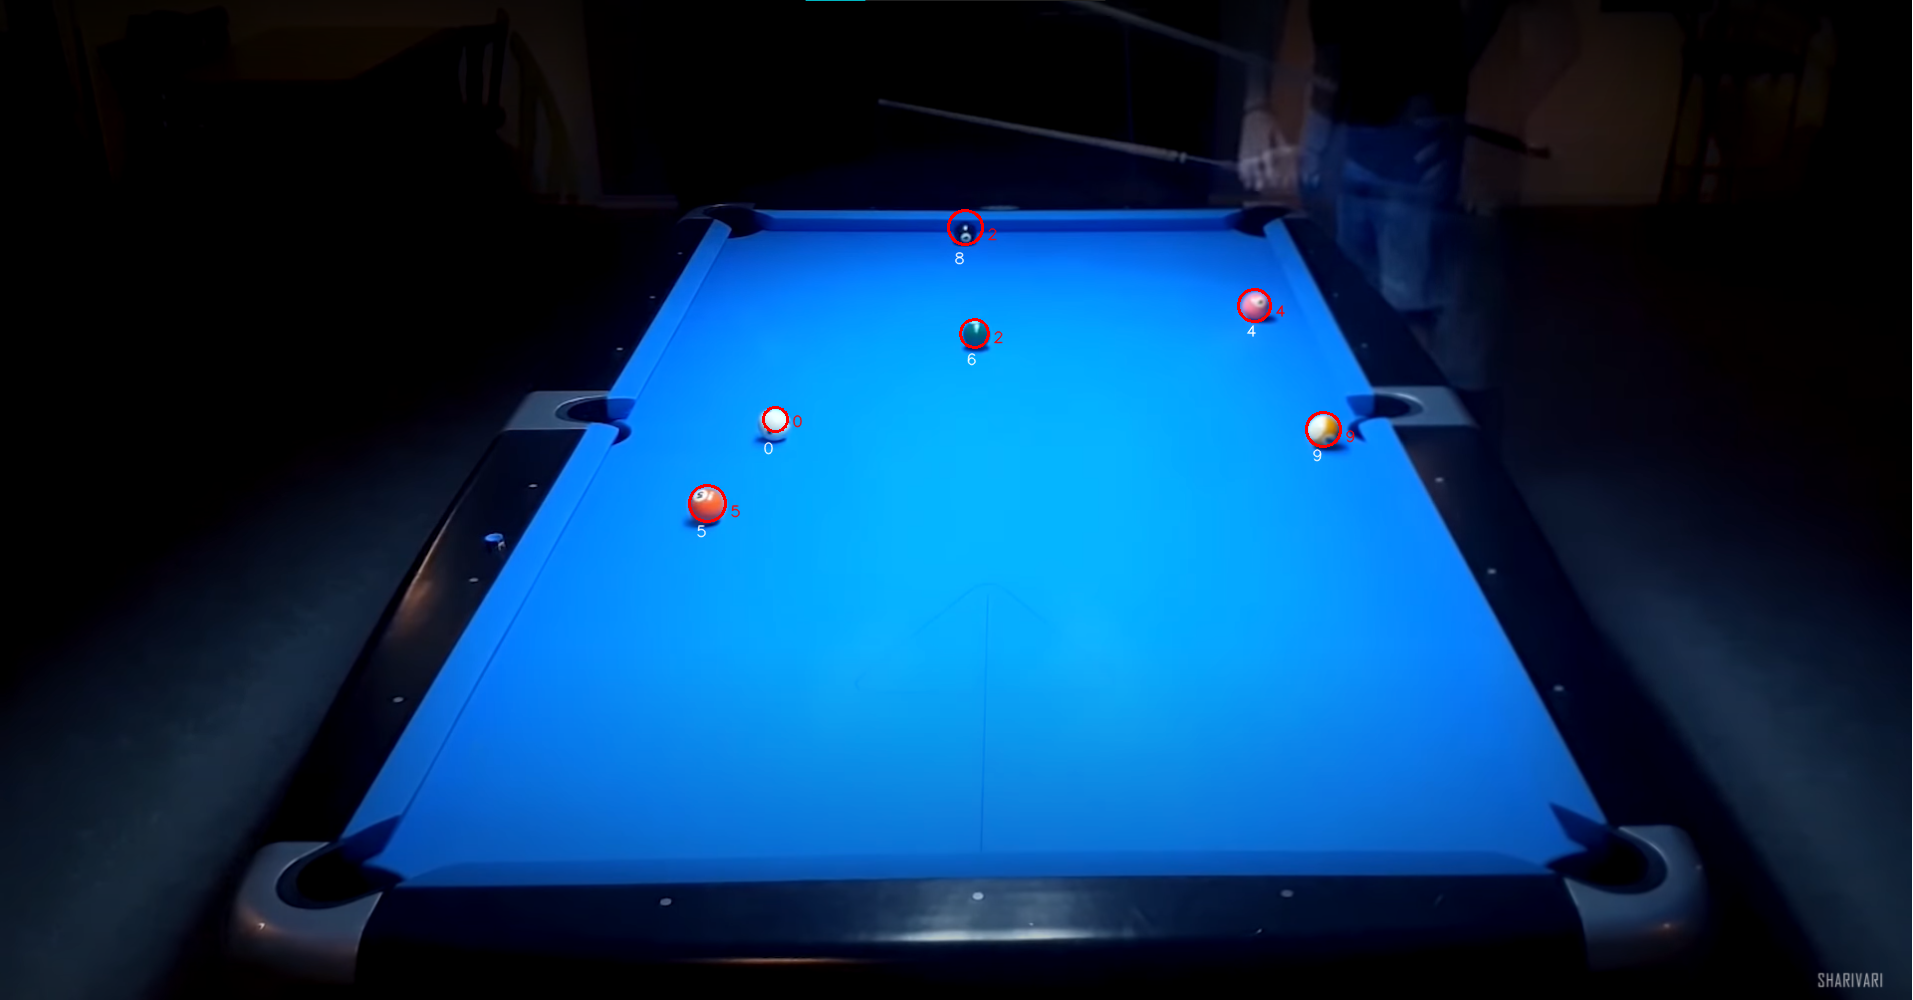

In [10]:
img_path = '/content/drive/MyDrive/DS102-final-project/billiards-game/dataset/all/hiu.5.png'
model_path = '/content/drive/MyDrive/DS102-final-project/model_checkpoints/RFC_model_best.sav'

add_ground_truth = 1

img_classified = detection_and_classification(img_path, model_path)
if add_ground_truth:
    img_classified = ground_truth(img_classified, img_path)

cv2_imshow(img_classified)

In [ ]:
# img_path = '/content/drive/MyDrive/DS102-final-project/billiards-game/dataset/all/'
# model_path = '/content/drive/MyDrive/DS102-final-project/model_checkpoints/RFC_model_best.sav'
# result_path = '/content/drive/MyDrive/DS102-final-project/result/'

# for item in os.listdir(img_path): 
#     image_path = img_path + item

#     print('Runing {}'.format(item))
#     add_ground_truth = 1
#     img_classified = detection_and_classification(image_path, model_path)
#     if add_ground_truth:
#         img_classified = ground_truth(img_classified, image_path)
    
#     print('Saving to {}'.format(result_path + item))
#     cv2.imwrite(result_path+ item, img_classified)
# # cv2_imshow(img_classified)